In [27]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

[ 9.31074509e-03  1.57329562e-02 -3.57950365e-03 -5.28325260e-02
 -3.34432799e-03  1.21733459e-02 -2.26626796e-02 -2.35143072e-02
  1.41441124e-03  1.03467086e-02 -7.65930140e-03  2.40126069e-02
 -2.66821036e-03 -8.17109023e-02  1.73463123e-02 -5.30050714e-02
 -1.03845916e-02  1.89754662e-02 -3.24516373e-02 -4.94728261e-02
 -9.24621976e-03 -3.87999267e-02  3.34218629e-02 -6.17642294e-04
  2.34050276e-02  9.82735020e-03  6.09233341e-03 -1.57016598e-02
  1.08151330e-02 -4.91242249e-02 -1.62069076e-02  3.78521677e-02
  1.26471410e-02  4.74915763e-02 -1.09810060e-02 -2.57921765e-02
  2.60937067e-02 -3.17061062e-03  2.97462854e-03  2.78645877e-02
 -4.71630054e-03  6.96801213e-03 -3.03129551e-02 -1.17280752e-03
  3.10225358e-02  1.28688899e-02  5.51131069e-02  9.48181034e-03
  4.31146040e-03 -2.62087464e-03  1.76957091e-02 -2.18906503e-02
  1.15608468e-02  5.45135653e-02  2.98593420e-03 -2.33041143e-02
  4.15581315e-02 -5.90082819e-02 -2.08765811e-02  2.57178467e-02
  3.36020702e-02 -1.54972

/var/folders/0h/qftfxs455z16g9wvd2yyl2g40000gp/T/ipykernel_60300/3131104020.py:11: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  W = np.random.multivariate_normal(mu, sigma * dt, N)


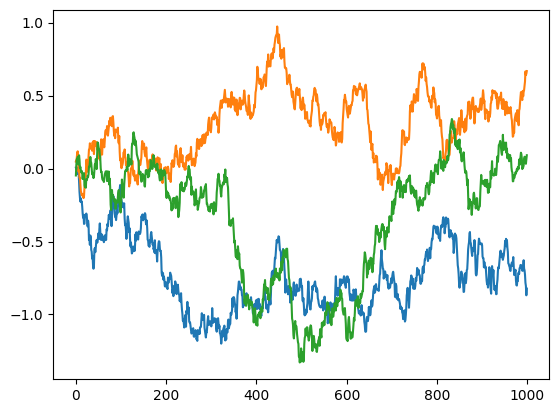

In [25]:
# sigma = [[1, rho], [rho,1]]
# mu = [[m1], [m2]]
#W_t = normal(mu, sigma)

rho = -0.5
N = 1000
t_time = 1.0 
dt = t_time/N
mu = np.array([0,0,0])
sigma = np.array([[1, 1, rho], [1, rho,1] ,[rho, 1, 1]])
W = np.random.multivariate_normal(mu, sigma * dt, N)
# Wt = W[:, 0]
print(Wt)
print(W)
print(W.cumsum(axis=0))
plt.plot(W.cumsum(axis=0))



In [23]:
print(np.corrcoef(W.T))

[[1.         0.00623483 0.01552202]
 [0.00623483 1.         0.00299435]
 [0.01552202 0.00299435 1.        ]]


Stochastic Volatility and Relationship to Asset Returns 


Volatility is treated as a Random Variable
Follows OU-Process
A temporally homogeneous Ornstein–Uhlenbeck process can be represented as a scaled, time-transformed Wiener process


Simulating Heston Path


In [ ]:
def gen_heston_path(S_0, r,steps, N_pth, kappa, theta, xi, rho, v_0, total_time=1.0, ret_vol = False):
    dt = total_time/steps
    size = (N_pth,steps+1)
    prices = np.zeros(size)
    sigma= np.zeros(size)
    # S_t = S_0
    # v_t = v_0
    prices[:, 0] = S_0
    sigma[: , 0] = v_0
    for t in range(1, steps+1): 
        WT = np.random.multivariate_normal(np.array([0,0]), 
                                           np.array([[1, rho], [rho, 1]]),
                                           N_pth) * np.sqrt(dt)
        

        v_t = sigma[:, t-1]
        S_t = prices[:, t-1]

        S_nex = S_t * np.exp((r - 0.5*v_t) * dt + np.sqrt(v_t*dt) * WT[:, 0])
        v_nex = v_t + kappa * (theta - v_t) * dt + xi* np.sqrt(v_t)* WT[:, 1]
        v_nex = np.maximum(v_nex, 0)
        prices[:, t] = S_nex
        sigma[:, t] = v_nex


    if ret_vol: 
        return prices, sigma
    
    return prices


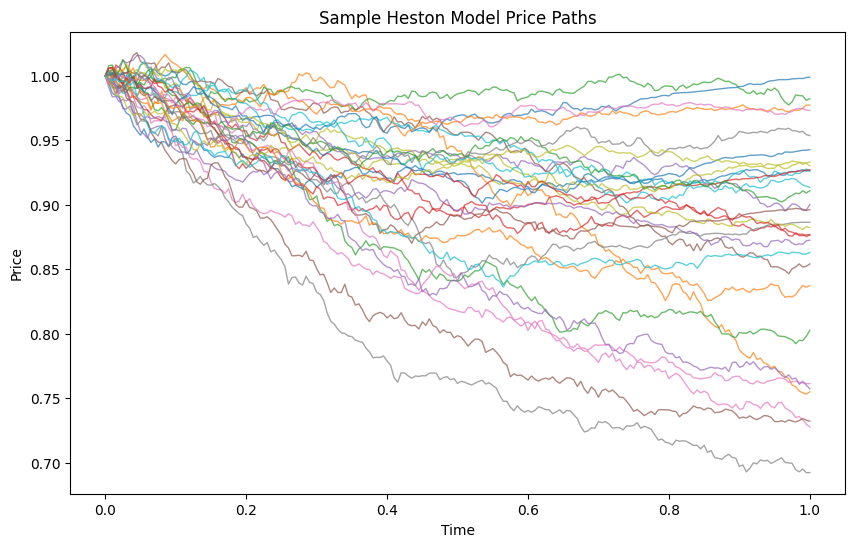

In [ ]:
# kappa = 2
# steps = 200
# N_paths = 50000
# v_0 = 0.7
# xi = 0.6
# r = 0.06
# theta = 0.04
# rho = -0.7
# S = 100
# T = 1.0



paths = gen_heston_path(S, r, steps, N_paths, kappa, theta, xi, rho, v_0)

plt.figure(figsize=(10,6))
for i in np.random.choice(N_paths, size=30, replace=False):
    plt.plot(np.linspace(0, T, steps+1), paths[i, :], lw=1, alpha=0.7)

plt.title("Sample Heston Model Price Paths")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

Deep Hedging Paper

In [62]:
from tensorflow.keras import layers, Model,optimizers
import tensorflow as tf
from tqdm import trange

In [72]:

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
N_train_paths = 20000
N_test_paths = 20000
batch_size = 256
epochs = 2000
learning_rate =5e-4
steps = 30
hid_dim = 17 


s0 = 100.0
v0 = 0.04 
T      = 30/365.0  # maturity ~ 1.5 months
steps  = 30        # daily rebalancing
N_pth  = 10000     # number of simulated paths

r      = 0.0       # risk-free rate
kappa  = 1.0       # mean reversion speed
theta  = 0.04      # long-run variance
xi     = 0.5       # vol of vol
rho    = -0.7      #

epsilon = 0.0
risk_measure = 'entropic'
ent_lambda = 1.0
cvar_a = 0.5
K = s0 

activation = tf.nn.relu


def heston_path(S_0, r,steps, N_pth, kappa, theta, xi, rho, v_0, total_time = T, ret_vol = False):
    dt = total_time/steps
    size = (N_pth,steps+1)
    prices = np.zeros(size)
    sigma= np.zeros(size)
    prices[:, 0] = S_0
    sigma[: , 0] = v_0
    d = 4*kappa*theta/(xi**2)
    c = (xi**2*(1-np.exp(-kappa*dt)))/(4*kappa)
    for t in range(1, steps+1): 
        WT = np.random.multivariate_normal(np.array([0,0]), 
                                           np.array([[1, rho], [rho, 1]]),
                                           N_pth) * np.sqrt(dt)
        v_t = sigma[:, t-1]
        S_t = prices[:, t-1]
        S_nex = S_t * np.exp((r - 0.5*v_t) * dt + np.sqrt(np.maximum(v_t, 1e-10)*dt) * WT[:, 0])
        lam = (4*kappa*np.exp(-kappa*dt)*v_t)/(xi**2*(1-np.exp(-kappa*dt)))
        ncx2 = np.random.noncentral_chisquare(d, lam, size=N_pth)
        v_nex = c*ncx2
        prices[:, t] = S_nex
        sigma[:, t] = v_nex
    if ret_vol: 
        return prices, sigma
    return prices



def var_swap(S_path, V_paths, T):
    N_pths, steps = S_path.shape
    n_steps = steps - 1 
    dt = T/n_steps
    S_2 = np.zeros_like(S_path)

    for t in range(steps): 
        if t == n_steps: 
            S_2[:, t] = 0.0
        else: 
            S_2[:, t] = np.sum(V_paths[:, t+1:], axis=1) * dt
    return S_2


def payoff_func(ST, K): 
    payoff = np.maximum(0.0, ST-K)
    return payoff


def trade_costs(prev_p, new_p, S_mid, e): 
    trade = new_p - prev_p
    cost = e * np.sum(np.abs(trade) * S_mid,axis=1)
    return trade, cost


#Semirecurrent Net
def build_hedge_net(ip_dim, hid_dim, op_dim):
    ik = layers.Input(shape=(ip_dim, ), dtype=tf.float32, name='Input_k')
    prev_pos_layer = layers.Input(shape=(op_dim, ), dtype=tf.float32, name="Prev_pos")
    x = layers.Concatenate()([ik, prev_pos_layer])
    x = layers.Dense(hid_dim, activation=activation)(x)
    x = layers.Dense(hid_dim, activation=activation)(x)
    out = layers.Dense(op_dim,activation=None)(x)
    model = Model([ik, prev_pos_layer], out)
    return model

@tf.function
def entropic_convex_risk( terminal_val, lam): 

    #CHANGE IN CODE
    # expectation = tf.reduce_mean(tf.exp(-lam * terminal_val))
    x = -lam * terminal_val
    x = tf.clip_by_value(x, -50.0, 50.0)
    expectation = tf.reduce_mean(tf.exp(x))
    minimizer = (1.0/lam) * tf.math.log(expectation + 1e-20)
    return minimizer

@tf.function
def cvar(terminal_pnl, alpha):
    loss = -terminal_pnl
    loss_order = tf.sort(loss)
    i = tf.cast(tf.floor(alpha * tf.cast(tf.shape(loss)[0], tf.float32)), tf.int32)
    i = tf.clip_by_value(i, 0, tf.shape(loss)[0]-1)
    var_a = loss_order[i]
    tail = tf.boolean_mask(loss,loss >= var_a)
    if tf.shape(tail)[0] == 0: 
        mean = tf.reduce_mean(loss)
        return mean 
    return tf.reduce_mean(tail) / (1.0-alpha + 1e-12)


S_train, V_train = heston_path(s0, r,steps, N_train_paths, kappa ,theta, xi, rho, v0, ret_vol=True)
S_test, V_test = heston_path(s0, r,steps, N_test_paths, kappa ,theta, xi, rho, v0, ret_vol=True)
S2_train = var_swap(S_train, V_train, T)
S2_test = var_swap(S_test, V_test, T)

def feature_build(S_paths, V_paths): 
    n_pths, n_pths_p1 = S_paths.shape
    feature_vec = np.zeros((n_pths, n_pths_p1, 2), dtype=np.float32) 
    feature_vec[:,:,0] = np.log(S_paths)
    feature_vec[:, :, 1] = V_paths
    return feature_vec

feature_vec_train = feature_build(S_train,V_train)
feature_vec_test = feature_build(S_test, V_test)

asset_train = np.stack([S_train, S2_train], axis=-1).astype(np.float32)
asset_test = np.stack([S_test, S2_test], axis=-1).astype(np.float32)

Z_train = payoff_func(S_train[:, -1], K).astype(np.float32)
Z_test= payoff_func(S_test[:, -1], K).astype(np.float32)

ip_dim = feature_vec_train.shape[-1]
op_dim = 2 

per_step_model = []
for _ in range(steps): 
    per_step_model.append(build_hedge_net(ip_dim, hid_dim, op_dim))

all_vars =[]
for model in per_step_model: 
    all_vars += model.trainable_variables
optimizer = optimizers.Adam(learning_rate=learning_rate)


def test_objective():
    term_pnls = evaluate(N_test_paths)
    return estimate_rho_from_sample(term_pnls, measure=risk_measure)

#per batch ? 
@tf.function
def forward(batch_i): 
    Fe = tf.gather(tf.constant(feature_vec_train), batch_i)
    Asset = tf.gather(tf.constant(asset_train),batch_i)
    Zb = tf.gather(tf.constant(Z_train), batch_i)
    B = tf.shape(Fe)[0]

    prev_pos = tf.zeros((B, 2), dtype=tf.float32)
    cum_c= tf.zeros((B,), dtype=tf.float32)
    pnl_accum = tf.zeros((B,), dtype=tf.float32)

    for k in range(steps): 
        ik = Fe[:, k, :]
        new_pos = per_step_model[k]([ik, prev_pos])
        S_mid = Asset[:, k,:]
        trade = new_pos - prev_pos
        c = epsilon * tf.reduce_sum(tf.abs(trade) * S_mid, axis=-1)
        cum_c += c

        dS = Asset[:, k+1, :] - Asset[:, k, :]
        pnl_accum += tf.reduce_sum(prev_pos* dS, axis=-1)
        prev_pos = new_pos


    S_t = Asset[:, -1, :] 
    final_trde = -prev_pos
    final_c = epsilon * tf.reduce_sum(tf.abs(final_trde) * S_t, axis=-1)
    cum_c +=final_c

    terminal_pnl = -Zb + pnl_accum - cum_c


    if risk_measure == 'entropic': 
        loss = entropic_convex_risk(terminal_pnl, ent_lambda)
    elif risk_measure == 'cvar': 
        loss = cvar(terminal_pnl, cvar_a)
    else: 
        loss = tf.reduce_mean(tf.square(terminal_pnl))

    return loss, terminal_pnl


print('Start Training...')

n_batches = N_train_paths //batch_size
idxs = np.arange(N_train_paths)
loss_hist = []

for step in trange(epochs): 
    batch_idx = np.random.choice(idxs, size=batch_size, replace=False)
    with tf.GradientTape() as tape: 
        loss_val, terminal_pnl_batch = forward(batch_idx)
    grads = tape.gradient(loss_val, all_vars)
    
    #ADDED CODE
    grads = [g if g is not None else tf.zeros_like(v) for g, v in zip(grads, all_vars)]
    grads, _ = tf.clip_by_global_norm(grads, 1.0)
    optimizer.apply_gradients(zip(grads, all_vars))
    loss_hist.append(float(loss_val))
    if (step+1) % 200 == 0:
        test_val = test_objective()
        print(f"Step {step + 1}/{epochs} loss={loss_val.numpy()}")
        print(f'Test_loss ={test_val}')

def evaluate(n_paths_eval=10000):
    BATCH = 1024
    n_tot = Z_test.shape[0]
    terminal_pnls = []
    for start in range(0, n_tot, BATCH):
        end = min(start+BATCH, n_tot)
        idx = np.arange(start,end)
        # forward pass using numpy: use the trained TF models
        F = feature_vec_test[idx]
        A = asset_test[idx]
        prev_pos = np.zeros((len(idx), 2), dtype=np.float32)
        cum_cost = np.zeros((len(idx),), dtype=np.float32)
        pnl_accum = np.zeros((len(idx),), dtype=np.float32)
        for k in range(steps):
            Ik = F[:,k,:].astype(np.float32)
            new_pos = per_step_model[k]([Ik, prev_pos]).numpy()
            S_mid = A[:,k,:]
            trade = new_pos - prev_pos
            cost = epsilon * np.sum(np.abs(trade) * S_mid, axis=-1)
            cum_cost += cost
            dS = A[:,k+1,:] - A[:,k,:]
            pnl_accum += np.sum(prev_pos * dS, axis=-1)
            prev_pos = new_pos
        # liquidation
        S_T = A[:,-1,:]
        final_trade = -prev_pos
        final_cost = epsilon * np.sum(np.abs(final_trade) * S_T, axis=-1)
        cum_cost += final_cost
        term = -Z_test[idx] + pnl_accum - cum_cost
        terminal_pnls.append(term)
    terminal_pnls = np.concatenate(terminal_pnls, axis=0)
    return terminal_pnls


print("Evaluating on test set...")
term_pnls = evaluate(N_test_paths)




def estimate_rho_from_sample(terminal_vals, measure='entropic'):
    if measure == 'entropic':
        lam = ent_lambda
        x = -lam * terminal_vals
        x = np.clip(x, -50.0, 50.0)
        return (1.0/lam) * np.log(np.mean(np.exp(x))+1e-20)
    elif measure == 'cvar':
        loss = -terminal_vals
        var = np.quantile(loss, cvar_a)
        tail = loss[loss >= var]
        if tail.size == 0:
            return np.mean(loss)
        return tail.mean() / (1.0 - cvar_a)
    else:
        return -np.mean(terminal_vals)  

rho_minusZ = estimate_rho_from_sample(term_pnls, measure=risk_measure)

terminal_pnl0 = term_pnls + Z_test
rho_0 = estimate_rho_from_sample(terminal_pnl0, measure=risk_measure)
indifference_price_est = rho_minusZ - rho_0

print("Estimate summary:")
print(f"rho(-Z)   = {rho_minusZ:.6f}")
print(f"rho(0)    = {rho_0:.6f}")
print(f"p(Z) est. = {indifference_price_est:.6f}")
        


Start Training...


 10%|█         | 200/2000 [00:44<13:34,  2.21it/s]

Step 200/2000 loss=0.025868522003293037
Test_loss =-0.023659704253077507


 20%|██        | 400/2000 [01:27<12:04,  2.21it/s]

Step 400/2000 loss=-0.03401177376508713
Test_loss =-0.027145003899931908


 30%|███       | 600/2000 [02:11<10:32,  2.21it/s]

Step 600/2000 loss=-0.05143944174051285
Test_loss =-0.02851470187306404


 40%|████      | 800/2000 [02:54<09:01,  2.21it/s]

Step 800/2000 loss=-0.06404298543930054
Test_loss =-0.02941332571208477


 50%|█████     | 1000/2000 [03:37<07:32,  2.21it/s]

Step 1000/2000 loss=-0.02007770910859108
Test_loss =-0.031100347638130188


 60%|██████    | 1200/2000 [04:20<06:01,  2.21it/s]

Step 1200/2000 loss=-0.013826144859194756
Test_loss =-0.03308356553316116


 70%|███████   | 1400/2000 [05:04<04:40,  2.14it/s]

Step 1400/2000 loss=0.04765323922038078
Test_loss =-0.03494664654135704


 80%|████████  | 1600/2000 [05:47<03:00,  2.21it/s]

Step 1600/2000 loss=-0.06460680812597275
Test_loss =-0.04009919986128807


 90%|█████████ | 1800/2000 [06:30<01:30,  2.22it/s]

Step 1800/2000 loss=-0.11128807812929153
Test_loss =-0.0987773984670639


100%|██████████| 2000/2000 [07:13<00:00,  4.61it/s]

Step 2000/2000 loss=-2.844609022140503
Test_loss =-2.532381057739258
Evaluating on test set...


Estimate summary:
rho(-Z)   = -2.532381
rho(0)    = -2.656091
p(Z) est. = 0.123710
